In [108]:
import yfinance as yf
import pandas as pd
import numpy as np
from math import sqrt
from scipy.optimize import minimize
from scipy.stats import ttest_1samp
import plotly_express as px
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')


INTERVAL = '1d'


# Getting Data 

In [90]:

stocks = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "AMZN",  # Amazon.com, Inc.
    "GOOGL", # Alphabet Inc.
    "META",  # Facebook, Inc.
    "TSLA",  # Tesla, Inc.
    "NVDA",  # NVIDIA Corporation
    "JNJ",   # Johnson & Johnson
    "V",     # Visa Inc.
    "JPM",   # JPMorgan Chase & Co.
    "WMT",   # Walmart Inc.
    "PG",    # Procter & Gamble Co.
    "UNH",   # UnitedHealth Group Incorporated
    "DIS",   # The Walt Disney Company
    "HD",    # Home Depot, Inc.
    "INTC",  # Intel Corporation
    "CSCO",  # Cisco Systems, Inc.
    "KO",    # Coca-Cola Company
    "PFE",   # Pfizer Inc.
    "PEP"    # PepsiCo, Inc.
]


def getData(ticker, start_date = '2015-01-01', end_date = '2024-07-18', interval = '1d'):
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    return data

def build_df(stocks):
    num_assets = 0
    df = pd.DataFrame()
    for ticker in stocks:
        data = getData(ticker, interval=INTERVAL)
        if data.empty:
            continue
        data = data['Adj Close']
        data = data.rename(ticker)
        df = df.merge(data, how='outer', left_index=True, right_index=True)
        num_assets += 1
    
    market = getData('^GSPC', interval=INTERVAL)['Adj Close']

    return market.pct_change().dropna(), df.pct_change().dropna(), num_assets

# Calculating Expected Return using CAPM

Risk Free Rate = $r_0$
- 10 year government bond

Market Return = $M$
- Using S&P 500 returns as a benchmark
    - Take daily returns for a given period
    - calculate the pct_change daily, and get the average percentage change $m_a$
    - annualize $m_a$ by doing this : $M = (1+m_a)^{trading\_ days}-1$

beta = $\beta$
- for a stock $S$: 
- $\beta = \frac{COV(Stock,Benchmark)}{VAR(Benchmark)}$

Expected Return = $r_o + \beta * (M-r_0)$


In [91]:
def get_r_0(treasury_yield_symbol = "^TNX"):
    data = yf.download(treasury_yield_symbol, period="1d")['Adj Close'][-1]
    return float(data) /100

def get_M(market):
    mean = market.mean()
    if INTERVAL == '1d':
        return float((1+mean)**252 - 1)
    elif INTERVAL == '1mo':
        return float((1+mean)**12 - 1)
    elif INTERVAL == '1y':
        return float(mean)

def get_betas(df, market):
    betas = []
    for stock in df.columns:
        # np.cov returns a covariance matrix so we just take one of the non-diagonal entries
        beta = np.cov(df[stock], market)[0][1] / np.var(market)
        betas.append(beta)
    return np.array(betas)

# Applying the Optimization

- $W$ is the column vector of weights.
- $R$ is the column vector of expected returns
- $\Sigma$ is the Covariance Matrix

Need to:
- Minimize risk : $W^T\cdot\Sigma\cdot W$ $\newline$
and
- Maximize returns : $W^T\cdot R$ 

Under the constrains:
- sum of weights must be equal to 1 : $e^T \cdot W = 1$

With the bounds:
- no single weight can be greater than 0.3 : $\forall i, 0 \leq w_i \leq 0.3$


$R$ and $\Sigma$ are known, we need to find the set of suitable vectors $W$. aka the efficient frontier

In [92]:
def optimize(df, R, r_0 ,num_assets, objective = 1):
    Sigma = df.cov().values

    # objective functions
    def risk(W, Sigma):
        return sqrt(W.T @ Sigma @ W)
    def reward(W, R):
        return W.T @ R 

    def objective1(W, Sigma, R, r_0):
        return -( (reward(W, R) - r_0) / risk(W, Sigma) ) 
    
    def objective2(W, Sigma, R, risk_aversion):
        return risk_aversion*risk(W, Sigma) - (1-risk_aversion)*reward(W, R)

    # constraint
    constraints = [
        {'type': 'eq', 'fun': lambda W: np.sum(W) - 1}
    ]

    # bounds 
    bounds = [
        (0,0.2) for _ in range(num_assets)
    ]

    # initial guess - equal distribution
    init = np.array([1/num_assets] * num_assets)


    # minimize
    if objective == 1:
        result = minimize(
            objective1, 
            init, 
            args=(Sigma, R, r_0), 
            constraints=constraints,
            bounds=bounds,
            method='SLSQP'
            )
    
    elif objective == 2:
        result = minimize(
            objective2, 
            init, 
            args=(Sigma, R, 0.87), 
            constraints=constraints,
            bounds=bounds,
            method='SLSQP'
            )
    
    return result


# Running

In [93]:
# get all data
market, df, num_assets = build_df(stocks)

# risk free rate
r_0 = get_r_0("^TNX")
# r_0 = 0.041

# market return
M = get_M(market)

# beta
betas = get_betas(df, market)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [94]:
# expected returns using CAPM
expected_returns = r_0 + betas * (M - r_0)

# optimize
result = optimize(df=df, R=expected_returns, r_0=r_0, num_assets=num_assets, objective=1)

weights = result.x * 100

for stock, weight in zip(stocks, weights):
    weight = round(weight, 10)
    if weight:
        print(f"{stock}: {weight:.2f}")

print()
print(portfolio_sharpe(result.x, expected_returns, df.cov().values))
print()
print(portfolio_returns(result.x, expected_returns))

AAPL: 7.68
MSFT: 6.86
AMZN: 3.20
GOOGL: 4.79
META: 3.04
TSLA: 1.75
NVDA: 3.78
JNJ: 4.77
V: 6.49
JPM: 14.59
WMT: 2.10
PG: 2.81
UNH: 5.18
DIS: 4.71
HD: 8.60
INTC: 3.18
CSCO: 3.94
KO: 8.59
PFE: 2.86
PEP: 1.10

7.56881677403472

0.12992053351540905


# Testing Performance of Portfolio

1. First we generate 1000 random $W$'s and calculate the return based on our existing $R$
    - The random vector $W$ is defined where each $w_i$ is picked via the following rule - 0 with probability 0.5 and a random number above 0 with the probability 0.5.
    - Each $w_i$ is then divided by the sum of $W$ to ensure that the sum of the weights is eqial to 1
2. Then we check if our optimized set is statistically better than the randomly generated portfoilio using a t test.
    - $h_0$ - optimized portfoilio returns < sampled returns
    - $h_a$ - optimized portfoilio returns > sampled returns

In [95]:
def portfolio_sharpe(W, R, Sigma, r_0=0.041):
    return ((W.T @ R)-r_0) / sqrt(W.T @ Sigma @ W)

def portfolio_returns(W,R):
    return W.T @ R

def portfoilio_risk(W, Sigma):
    return sqrt(W.T @ Sigma @ W)

def generate_random_weight(num_assets, method):
    if method == 'distribution':
        W = []
        for _ in range(num_assets):
            if np.random.random() < 0.5:
                W.append(0)
            else:
                W.append(np.random.random())
        W = np.array(W)
        return W / W.sum()
    elif method == 'dirichlet':
        return np.random.dirichlet(np.ones(num_assets))

    
def generate_random_returns(R, num_assets, num_portfolios, method):
    metrics = []
    sigma =df.cov().values
    for _ in range(num_portfolios):
        W = generate_random_weight(num_assets, method)
        metrics.append((portfolio_returns(W, R), portfoilio_risk(W, sigma),W))
    return metrics
    


Ran multiple hypothesis tests on a sample of size 100 to check the percentage of rejects

In [9]:
# optimized portfolio
opt_return = portfolio_returns(result.x, expected_returns)


counter = 0
rejects = 0
for i in range(100):
    random_samples = generate_random_returns(expected_returns, num_assets, 100, 'distribution')
    random_returns = [r for r, _ , _ in random_samples]
    _, p_value = ttest_1samp(random_returns, opt_return, alternative='less')
    if p_value <0.05:
        rejects +=1
    counter+=1

str(rejects / counter * 100) + '%'

'60.0%'

## Reject NULL

In [109]:
num_portfolios = 200
random_samples = generate_random_returns(expected_returns, num_assets, num_portfolios, 'distribution')

random_returns = []
random_weights = []
random_risks = []
for returns, risks, weights in random_samples:
    random_returns.append(returns)
    random_weights.append(weights)
    random_risks.append(risks)

_, p_value = ttest_1samp(random_returns, opt_return, alternative='less')
if p_value <0.05:
    print("Reject the null hypothesis")
print(p_value)

Reject the null hypothesis
5.8585326409239856e-05


In [110]:

data = {
    'Return' : random_returns,
    'Risk' : random_risks,
    'Type' : ['Random']*num_portfolios
}
for i, stock in enumerate(stocks):
    data[stock] = [round(w[i],2) for w in random_weights]



data = pd.DataFrame(data)

row = {'Return' : opt_return,
       'Risk' : portfoilio_risk(result.x, df.cov().values),
       'Type' : ['Optimal']
       }
for i, stock in enumerate(stocks):
    row[stock] = round(result.x[i], 2)


row = pd.DataFrame(row)
data = pd.concat([data, row])


fig = px.scatter(data, x='Risk', y='Return', color='Type',
                 hover_data={stock: True for stock in stocks},
                 title="Random Portfolios: Return vs. Risk",
                 labels={'Risk': 'Risk', 'Return': 'Return'})


fig.update_layout(
    hovermode='closest',
    xaxis_title="Risk",
    yaxis_title="Return",
    title="Random Portfolios: Return vs. Risk"
)



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0.1 , 0.  , 0.12, ..., 0.06, 0.  , 0.  ],
                                   [0.  , 0.  , 0.  , ..., 0.  , 0.13, 0.16],
                                   [0.03, 0.06, 0.  , ..., 0.  , 0.  , 0.  ],
                                   ...,
                                   [0.16, 0.  , 0.1 , ..., 0.05, 0.12, 0.02],
                                   [0.01, 0.  , 0.  , ..., 0.  , 0.01, 0.23],
                                   [0.14, 0.  , 0.  , ..., 0.01, 0.06, 0.  ]]),
              'hovertemplate': ('Type=Random<br>Risk=%{x}<br>Re' ... 'customdata[19]}<extra></extra>'),
              'legendgroup': 'Random',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Random',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([0.01174728, 0.01202171, 0.01557046, 0.01281834, 0.01283349, 0.01168796,
                          0.01251831, 0.01551283, 0.0100623 , 0.01367904, 0.01197667, 0.01266764,
                          0.01164184, 0.01207332, 0.01075337, 0.01315246, 0.01289651, 0.0130787 ,
                          0.015022  , 0.01449538, 0.01130399, 0.01269396, 0.01285769, 0.01502682,
                          0.01314219, 0.01436361, 0.01127709, 0.01232295, 0.01129861, 0.01114175,
                          0.01274699, 0.01301006, 0.01136951, 0.01162658, 0.01134578, 0.01235967,
                          0.01201945, 0.01221976, 0.01344394, 0.01185078, 0.01125932, 0.01198237,
                          0.01191214, 0.01137451, 0.01186494, 0.01153043, 0.01181824, 0.01329204,
                          0.01429633, 0.01153554, 0.01394206, 0.01161671, 0.01189928, 0.01169962,
                          0.01329075, 0.01087677, 0.01244725, 0.01368476, 0.0124134 , 0.01144975,
                          0.01135337, 0.01147259, 0.01291908, 0.01058619, 0.01118664, 0.01427104,
                          0.01189134, 0.01262209, 0.01398431, 0.01325768, 0.01164844, 0.01106184,
                          0.01379568, 0.01389674, 0.01298984, 0.01144849, 0.01197326, 0.0113113 ,
                          0.01216063, 0.01195556, 0.01288143, 0.01202715, 0.01106126, 0.01270773,
                          0.01493252, 0.0121512 , 0.01236569, 0.01043137, 0.0122472 , 0.01075523,
                          0.01162181, 0.01268098, 0.01240987, 0.01233175, 0.01061506, 0.01121555,
                          0.01088361, 0.01328286, 0.01374979, 0.01263666, 0.01409177, 0.01291397,
                          0.01351751, 0.01152737, 0.01248655, 0.01192014, 0.01237686, 0.01218959,
                          0.01232721, 0.01487539, 0.01231319, 0.01261187, 0.01220727, 0.01380577,
                          0.01153239, 0.01305042, 0.01149623, 0.01293349, 0.01130629, 0.01221058,
                          0.01190416, 0.00983031, 0.01367751, 0.01223016, 0.01248102, 0.01141318,
                          0.01093965, 0.012226  , 0.01213771, 0.0129204 , 0.01234384, 0.01328106,
                          0.01126477, 0.01273823, 0.01225854, 0.01234223, 0.01382098, 0.01164218,
                          0.01121115, 0.01384525, 0.01350051, 0.0144113 , 0.0118557 , 0.01363805,
                          0.01312149, 0.01194686, 0.0111099 , 0.01440336, 0.01079642, 0.01021089,
                          0.01060688, 0.01184794, 0.01207902, 0.01146433, 0.01476879, 0.01103866,
                          0.01200553, 0.0143364 , 0.0124054 , 0.01043877, 0.013087  , 0.01157044,
                          0.01247944, 0.01172443, 0.01199189, 0.01318436, 0.01193773, 0.01408065,
                          0.01480426, 0.01076165, 0.01142574, 0.01275328, 0.01179142, 0.01266262,
                          0.01289749, 0.01223062, 0.01159277, 0.01175608, 0.01251645, 0.0109034 ,
                          0.01173448, 0.01281044, 0.01223076, 0.01437019, 0.0136586 , 0.01561827,
                          0.01215718, 0.01056704, 0.01081709, 0.0115

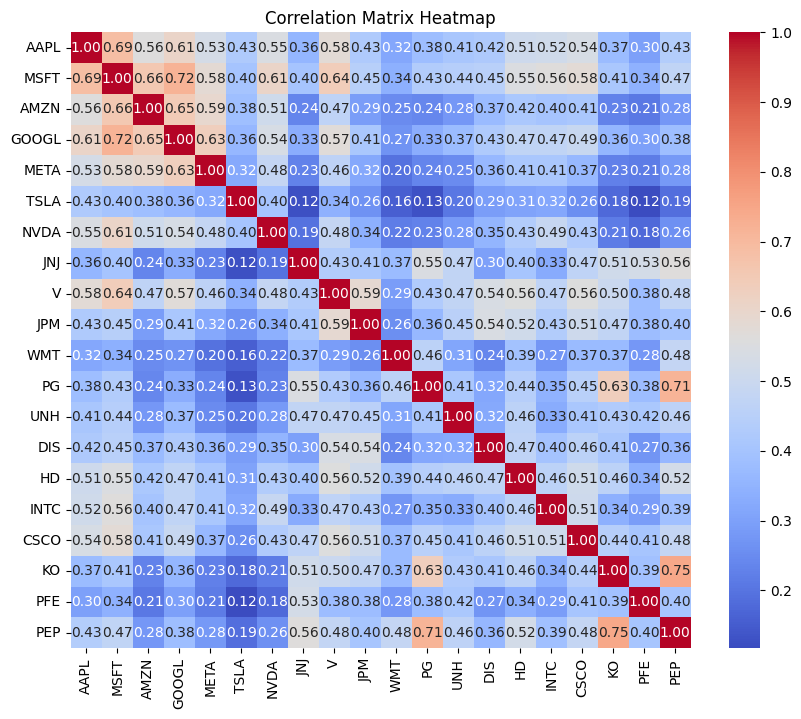

In [113]:
corr = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

## Fail to reject NULL

In [114]:
num_portfolios = 50
random_samples = generate_random_returns(expected_returns, num_assets, num_portfolios, 'distribution')

random_returns = []
random_weights = []
random_risks = []
for returns, risks, weights in random_samples:
    random_returns.append(returns)
    random_weights.append(weights)
    random_risks.append(risks)

_, p_value = ttest_1samp(random_returns, opt_return, alternative='less')
if p_value >0.05:
    print("Fail to reject the null hypothesis")
print(p_value)

Fail to reject the null hypothesis
0.20186765507921767


In [115]:
data = {
    'Return' : random_returns,
    'Risk' : random_risks,
    'Type' : ['Random']*num_portfolios
}
for i, stock in enumerate(stocks):
    data[stock] = [round(w[i],2) for w in random_weights]



data = pd.DataFrame(data)

row = {'Return' : opt_return,
       'Risk' : portfoilio_risk(result.x, df.cov().values),
       'Type' : ['Optimal']
       }
for i, stock in enumerate(stocks):
    row[stock] = round(result.x[i], 2)


row = pd.DataFrame(row)
data = pd.concat([data, row])


fig = px.scatter(data, x='Risk', y='Return', color='Type',
                 hover_data={stock: True for stock in stocks},
                 title="Random Portfolios: Return vs. Risk",
                 labels={'Risk': 'Risk', 'Return': 'Return'})


fig.update_layout(
    hovermode='closest',
    xaxis_title="Risk",
    yaxis_title="Return",
    title="Random Portfolios: Return vs. Risk"
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0.  , 0.18, 0.  , ..., 0.  , 0.17, 0.  ],
                                   [0.09, 0.  , 0.07, ..., 0.05, 0.  , 0.  ],
                                   [0.  , 0.03, 0.05, ..., 0.1 , 0.15, 0.  ],
                                   ...,
                                   [0.03, 0.34, 0.  , ..., 0.  , 0.01, 0.11],
                                   [0.  , 0.11, 0.  , ..., 0.  , 0.  , 0.  ],
                                   [0.09, 0.09, 0.  , ..., 0.  , 0.03, 0.05]]),
              'hovertemplate': ('Type=Random<br>Risk=%{x}<br>Re' ... 'customdata[19]}<extra></extra>'),
              'legendgroup': 'Random',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Random',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([0.01197687, 0.01188833, 0.01165994, 0.01407973, 0.01403467, 0.01215968,
                          0.01159955, 0.01163243, 0.01475601, 0.01168043, 0.01351498, 0.01059972,
                          0.01255321, 0.01211041, 0.01335653, 0.01152455, 0.01176737, 0.01389533,
                          0.01160408, 0.01287668, 0.01231131, 0.01160175, 0.01503998, 0.01253133,
                          0.01369203, 0.01299172, 0.01356249, 0.01360254, 0.01230171, 0.01113548,
                          0.01338696, 0.01278228, 0.01189755, 0.01350414, 0.01167962, 0.01185453,
                          0.01368756, 0.01314525, 0.01194988, 0.01507443, 0.01151998, 0.01099783,
                          0.01168989, 0.01199912, 0.01261312, 0.01297003, 0.01184586, 0.01364998,
                          0.01304158, 0.01238481]),
              'xaxis': 'x',
              'y': array([0.12652697, 0.12787291, 0.1254455 , 0.13873722, 0.14060315, 0.12925952,
                          0.12619677, 0.12432379, 0.14102913, 0.1242664 , 0.13566576, 0.11788311,
                          0.12854298, 0.12755554, 0.13627539, 0.1239497 , 0.12666998, 0.13707066,
                          0.12458062, 0.12407703, 0.12732947, 0.12437294, 0.13761665, 0.12462057,
                          0.13373635, 0.13523528, 0.13406769, 0.13172646, 0.12539178, 0.11892792,
                          0.1354206 , 0.13153437, 0.12406351, 0.13608063, 0.12506011, 0.12727483,
                          0.13110224, 0.13786743, 0.12743588, 0.13304005, 0.12096698, 0.11601287,
                          0.12374918, 0.12844443, 0.13361066, 0.1275078 , 0.12547601, 0.13609798,
                          0.12952026, 0.13084437]),
              'yaxis': 'y'},
             {'customdata': array([[0.08, 0.07, 0.03, 0.05, 0.03, 0.02, 0.04, 0.05, 0.06, 0.15, 0.02,
                                    0.03, 0.05, 0.05, 0.09, 0.03, 0.04, 0.09, 0.03, 0.01]]),
              'hovertemplate': ('Type=Optimal<br>Risk=%{x}<br>R' ... 'customdata[19]}<extra></extra>'),
              'legendgroup': 'Optimal',
              'marker': {'color': '#EF553B', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Optimal',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([0.01174827]),
              'xaxis': 'x',
              'y': array([0.12992053]),
              'yaxis': 'y'}],
    'layout': {'hovermode': 'closest',
               'legend': {'title': {'text': 'Type'}, 'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Random Portfolios: Return vs. Risk'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Risk'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Return'}}}
})